In [2]:
from datetime import datetime, timedelta
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
datelist = pd.date_range(datetime.today(), periods=100).tolist()
from time import sleep
import dask.dataframe as dd
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import os
import glob
from datetime import date

from uuid import uuid4


import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import geopandas as gpd
import seaborn as sns

import dask.dataframe as dd
import geopandas as gpd
from detect_heatwaves import detect
from datetime import timedelta
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt



In [3]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/THI/nigeria/daily_max_THI.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df.month.unique()
full_df = full_df[~full_df['month'].isin([5])]

full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]


In [4]:
full_df['datetime'].max()

Timestamp('2022-04-30 00:00:00')

In [5]:
full_df['location'].value_counts().value_counts()

906    774
Name: location, dtype: int64

## Find heat waves, heat wave lengths and assign unique heatwave IDs

In [6]:
full_df['datetime'].min()

Timestamp('2017-11-01 00:00:00')

In [7]:
full_df['datetime'].min()

Timestamp('2017-11-01 00:00:00')

In [8]:
full_df['pct'] = full_df.groupby('location')['thi'].transform(lambda x: x.rank(pct=True))

In [9]:
full_df

,Unnamed: 0,datetime,number,spatial_ref,t2m,d2m,rh,thi,adm2,adm1,day,month,year,location,datetime_ord,pct
0,0,2017-11-01,0.0,0.0,28.174225,25.033234,99.587950,32.159570,Aba North,Abia,1,11,2017,"Aba North, Abia",736634,0.039735
1,1,2017-11-02,0.0,0.0,27.015778,24.732452,99.567060,30.284114,Aba North,Abia,2,11,2017,"Aba North, Abia",736635,0.019868
2,2,2017-11-03,0.0,0.0,30.893951,24.279938,99.502440,36.705100,Aba North,Abia,3,11,2017,"Aba North, Abia",736636,0.622517
3,3,2017-11-04,0.0,0.0,29.275543,25.197662,98.247590,35.215496,Aba North,Abia,4,11,2017,"Aba North, Abia",736637,0.317881
4,4,2017-11-05,0.0,0.0,29.896637,24.265290,99.784990,34.818764,Aba North,Abia,5,11,2017,"Aba North, Abia",736638,0.254967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708977,708977,2022-04-26,0.0,0.0,38.436810,20.194227,62.490185,38.182693,Zuru,Kebbi,26,4,2022,"Zuru, Kebbi",738271,0.880795
708978,708978,2022-04-27,0.0,0.0,38.924260,19.218203,57.643166,38.252332,Zuru,Kebbi,27,4,2022,"Zuru, Kebbi",738272,0.889625
708979,708979,2022-04-28,0.0,0.0,36.754272,20.849780,69.864105,38.670904,Zuru,Kebbi,28,4,2022,"Zuru, Kebbi",738273,0.915011
708980,708980,2022-04-29,0.0,0.0,37.291820,20.036774,67.291970,37.555783,Zuru,Kebbi,29,4,2022,"Zuru, Kebbi",738274,0.835541


In [10]:
#create dictionary containing each county's heatwave periods
heatwave_dic = {}
for adm2 in full_df['location'].unique():
    adm2_df = full_df[(full_df['location'] == adm2)]
    adm2_df.reset_index(inplace=True)
    adm2_df = adm2_df.sort_values(by='datetime')
    adm2_df.drop_duplicates(['adm2', 'datetime'], inplace=True)
    heatwave_dic[adm2] = detect(adm2_df['datetime_ord'].values, adm2_df['thi'].values, pctile=90, minDuration=2)

    
heatwave_dates = {}
consec_dates = {}
heatwave_IDs = {}
for adm2 in heatwave_dic.keys(): 
    consec_dates[adm2] = {}
    heatwave_dates[adm2] = []
    heatwave_IDs[adm2] = {}


    heatwave_starts = heatwave_dic[adm2]['date_start']
    heatwave_ends = heatwave_dic[adm2]['date_end']
    for i in range(len(heatwave_starts)):
        heatwave_code = str(uuid4())
        heatwave_days = pd.date_range(heatwave_starts[i],heatwave_ends[i],freq='d')
        length_heatwaves = len(heatwave_days)
        consec_dates[adm2][heatwave_days[0]] = length_heatwaves
        for item in heatwave_days:
            heatwave_dates[adm2].append(item)
            heatwave_IDs[adm2][item] = heatwave_code
            
            
heat_df = pd.DataFrame.from_dict(heatwave_dates, orient='index').unstack().reset_index()
heat_df.rename(columns={'level_1':'location', 0:'datetime'}, inplace=True)


heat_df.dropna(inplace=True)
heat_df['heatwave']=1

In [11]:
full_df = full_df.merge(heat_df, on=['location', 'datetime'], how='left')

full_df['heatwave'] = full_df['heatwave'].replace(np.nan, 0)

In [12]:
full_df[full_df['heatwave'] == 1]['pct'].min()

0.9006622516556292

In [13]:
full_df['pct'] = full_df.groupby('location')['thi'].transform(lambda x: x.rank(pct=True))

In [14]:
len(full_df[full_df['heatwave'] == 1]['location'].unique())

774

In [15]:
codes = pd.DataFrame.from_dict(heatwave_IDs, orient='index').unstack().reset_index()

In [16]:
codes.columns=['datetime', 'location', 'heat_ID']

In [17]:
codes.dropna(inplace=True)

In [18]:
consec = pd.DataFrame.from_dict(consec_dates, orient='index').unstack().reset_index()

In [19]:
consec.columns= ['datetime', 'location', 'Heat Wave Duration']

In [20]:
consec.dropna(inplace=True)

In [21]:
full_df = full_df.merge(codes, on=['datetime', 'location'])

In [22]:
full_df = full_df.merge(consec, on=['datetime', 'location'], how='left')

In [23]:
full_df['heat_ID'].value_counts()

874d28c2-0000-4b4f-838d-d5d93097530f    18
c647aa9c-95db-4325-b3d4-b8c9ebabcb01    18
fe5fe0aa-5a96-4b43-9968-9c0d4eb1acba    18
dd63a09a-5e21-49d7-83a6-c6d10e7b185e    18
701fba40-29f1-4d5e-b198-6fde5a56a19d    18
                                        ..
e1212989-8714-4aa6-ba7c-7e624b1a27c5     2
d66ec02e-ce30-4701-9ca5-a8042248a21b     2
88e85f74-c140-4f16-b903-1a8c31433759     2
bcb6307b-465a-4015-bfa8-044f68392080     2
ac338dbc-ae94-49cb-9ee3-2ae7d38c9dd5     2
Name: heat_ID, Length: 13160, dtype: int64

In [24]:
full_2022 = full_df[full_df['datetime'] >= '2021-10-01']

In [25]:
len(full_2022['adm2'].unique())

768

In [26]:
gdf = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/nigeria/clean_shp.shp')

In [27]:
for_plot = gdf.merge(full_df.groupby(['adm2', 'adm1'])['thi'].mean().reset_index(), left_on=['adm2', 'adm1'], right_on=['adm2', 'adm1'])

Text(0.5, 1.0, 'Nigeria 2018-2022 heatwave temperatures (C)')

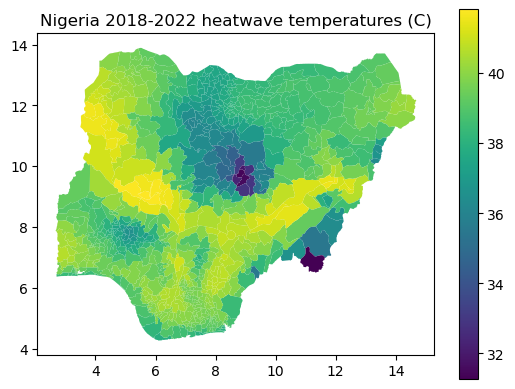

In [28]:
for_plot.plot(column='thi', legend=True)
plt.title("Nigeria 2018-2022 heatwave temperatures (C)")

In [29]:
#changed from v2
full_2022.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/nigeria/THI_nigeria_90_2022.csv')
full_df.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/nigeria/THI_nigeria_90_2018_2022.csv')